# Data Preparation, Pipelines & Model 

In [1]:
# Modules importeren
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

# Dataset importeren 
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv")

# Target variabele maken 
target = 'song_popularity'
#df.drop(columns=["song_name"], inplace=True) # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken 

### Phase 3: Data Preparation

In [2]:
# 2 nummers droppen
df = df.drop([7119, 11171]).reset_index(drop=True)

In [3]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18833
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14466


In [4]:
df.drop(columns=["song_name"], inplace=True) # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken 

In [5]:
X = df.drop(columns=[target], axis=1)
y = df[target]

## Winsorizer Class

In [6]:
# BaseEstimator zorgt dat sklearn mijn class kan herkennen als model/stap in pipeline.
# TransformerMixin geeft .fit_transform().
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, kolommen): 
        self.kolommen = kolommen 
        self.grenzen_ = None # '_' betekent dat het attribuut pas beschikbaar wordt, nadat fit() is uitgevoerd. 
                             # None, omdat de grenzen nog niet bestaan -- worden berekend bij fit().

    def fit(self, X, y=None):
        """Bereken de onder- en bovengrenzen per kolom met interkwartielafstand-regel."""
        self.grenzen_ = {}
        for kolom in self.kolommen:
            Q1 = X[kolom].quantile(0.25)
            Q3 = X[kolom].quantile(0.75)
            IKR = Q3 - Q1 
            ondergrens = Q1 - 1.5 * IKR
            bovengrens = Q3 + 1.5 * IKR
            self.grenzen_[kolom] = (ondergrens, bovengrens)
        return self 
    
    def transform(self, X):
        """Winsoriseer uitschieters: vervang alle waardes buiten de grenzen met de dichtstbijzijnde grenswaarde."""
        X = X.copy() # Kopie maken van data 
        for kolom, (ondergrens, bovengrens) in self.grenzen_.items():
            X.loc[X[kolom] < ondergrens, kolom] = ondergrens 
            X.loc[X[kolom] > bovengrens, kolom] = bovengrens 
        return X
    def get_feature_names_out(self, input_features=None):
        return np.array(self.kolommen)

## Key Cyclic Encoder class 

In [7]:
class ToonsoortCyclischeEncoder(BaseEstimator, TransformerMixin):
    """
    Cyclisch encoden van de toonsoort/key (0-11) met sinus en cosinus. 
    """

    def __init__(self, kolom='key', max_waarde=12):
        self.kolom = kolom
        self.max_waarde = max_waarde
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X = X.copy()
        k = X[self.kolom]
        X[f'{self.kolom}_sin'] = np.sin(2 * np.pi * k/self.max_waarde)
        X[f'{self.kolom}_cos'] = np.cos(2 * np.pi * k/self.max_waarde)
        return X.drop(columns=[self.kolom])
    def get_feature_names_out(self, input_features=None):
        return np.array(self.kolommen)

### Phase 4: Modeling 

Supervised learning, omdat je de uitkomst al hebt 
<br>
Supervised learning heeft 2 hoofdtakken: regressie en classificatie 
<br>
RMSE 
<br>
Meervoudige lineare regressie 
<br>
Logistieke lineare regressie is classification 
<br>
Random forests is het begin van dat machine learning slim werd 

In [8]:
def nieuwe_features(X):
    X = X.copy()
    X['energy_dance'] = X['energy'] * X['danceability']
    X['tempo_loudness'] = X['tempo'] * X['loudness']
    X['valence_energy'] = X['audio_valence'] * X['energy']
    X['acoustic_energy_ratio'] = X['acousticness'] / (X['energy'] + 0.001)
    X['speech_loudness_ratio'] = X['speechiness'] / (abs(X['loudness']) + 0.001)
    X['acoustic_dance_ratio'] = X['acousticness'] / (X['danceability'] + 0.001)
    X['energy_per_tempo'] = X['energy'] / (X['tempo'] + 0.001)
    X['valence_dance'] = X['audio_valence'] * X['danceability']
    X['duration_energy_ratio'] = X['song_duration_ms'] / (X['energy'] + 0.001)

    # Niet - lineaire verbanden 
    X['energy_sq'] = X['energy'] ** 2
    X['tempo_log'] = np.log1p(X['tempo'])
    X['loudness_sq'] = X['loudness'] ** 2
    return X
feature_engineering = FunctionTransformer(nieuwe_features, validate=False)

In [9]:
# Train en test set maken 
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state = 42
)

In [10]:
# Kolommen indelen
kolommen_winsoriseren = ['song_duration_ms', 'loudness', 'tempo']
categorische_kolommen = ['time_signature']
cyclische_kolommen = ['key']

#Alle nummerieke kolommen behalve target
numerieke_kolommen = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
overige_kolommen = [
    c for c in numerieke_kolommen 
    if c not in kolommen_winsoriseren + categorische_kolommen + cyclische_kolommen
]

## Pipelines 

In [11]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('winsor_scale', Pipeline ([ # Pipeline zorgt dat alle transformaties in de serie worden uitgevoerd op dezelfde kolommen. 
        ('winsor', Winsorizer(kolommen=kolommen_winsoriseren)),
        ('scaler', StandardScaler()) # Dit moet hier in winsor_scale, omdat anders de gewinsoriseerde kolommen weer weggegooid worden. 
    ]), kolommen_winsoriseren),
    
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorische_kolommen),
    
    ('key_cyclisch', Pipeline([
        ('encoder', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12)),
        ('scaler', StandardScaler())
    ]), cyclische_kolommen),
    ('scale_overige_kolommen', StandardScaler(), overige_kolommen),
],
remainder=StandardScaler()) # Anders vallen nieuwe features weg 

In [12]:
# Lineaire Regressie 
lineair_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

In [13]:
# Trainen en evalueren 
lineair_pipeline.fit(X_train, y_train)
y_pred = lineair_pipeline.predict(X_test)

In [14]:
random_forest_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
param_grid = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [6, 8, 10, 12, 14],
    'model__min_samples_split': [2, 4, 6, 8],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


In [16]:
beste_model = grid_search.best_estimator_
y_pred_rf = beste_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

# Evaluatie
print("Beste parameters:", grid_search.best_params_)
print(f"Cross-val (train) R²: {grid_search.best_score_:.4f}")
print(f"Test R²: {r2_rf:.4f}")
print(f"Test RMSE: {rmse_rf:.4f}")

Beste parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__n_estimators': 400}
Cross-val (train) R²: 0.0580
Test R²: 0.0520
Test RMSE: 20.0811


In [17]:
def get_feature_names_from_pipeline(model):
    pre = model.named_steps['preprocess']
    try:
        names = pre.get_feature_names_out()
    except Exception:
        names = []
        for name, trans, cols in pre.transformers_:
            if name == 'remainder' or trans == 'drop':
                continue
            if hasattr(trans, 'get_feature_names_out'):
                try:
                    n = trans.get_feature_names_out(cols)
                except Exception:
                    n = cols
            elif isinstance(trans, Pipeline):
                last = trans.steps[-1][1]
                if hasattr(last, 'get_feature_names_out'):
                    n = last.get_feature_names_out(cols)
                else:
                    n = cols
            else:
                n = cols
            names.extend(n)
    return names

Aantal feature_names: 17
Aantal importances: 30
⚠️ Feature name mismatch: 29 namen, 30 importances.
→ Dit komt doordat FunctionTransformer of OneHotEncoder extra kolommen maakt.
Alleen de eerste 29 features worden gebruikt.



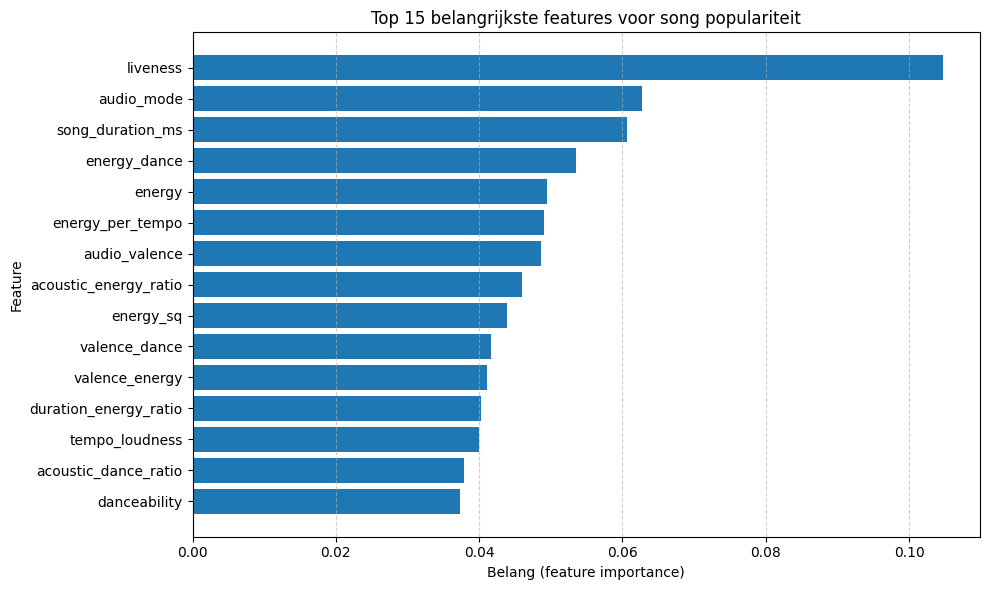

,Feature,Importance
13,liveness,0.104660
14,audio_mode,0.062677
0,song_duration_ms,0.060659
17,energy_dance,0.053476
11,energy,0.049445
23,energy_per_tempo,0.048982
16,audio_valence,0.048605
20,acoustic_energy_ratio,0.045948
26,energy_sq,0.043865
24,valence_dance,0.041667


Model heeft 30 features.
Preprocessor rapporteert 17 namen.

Er lijken 13 namen te ontbreken — waarschijnlijk door FunctionTransformer (feature_engineering).


In [18]:
# ---------------------------
# Feature importances ophalen + mismatch veilig afhandelen
# ---------------------------

# 1️⃣ Namen uit de pipeline halen
feature_names = get_feature_names_from_pipeline(beste_model)
importances = beste_model.named_steps['model'].feature_importances_

# 2️⃣ Check hoeveel features er zijn
print("Aantal feature_names:", len(feature_names))
print("Aantal importances:", len(importances))

# ---------------------------
# Feature names uitbreiden met engineered features
# ---------------------------

extra_features = [
    'energy_dance', 'tempo_loudness', 'valence_energy',
    'acoustic_energy_ratio', 'speech_loudness_ratio',
    'acoustic_dance_ratio', 'energy_per_tempo',
    'valence_dance', 'duration_energy_ratio',
    'energy_sq', 'tempo_log', 'loudness_sq'
]

# Combineer automatisch alle namen
combined_feature_names = list(feature_names) + extra_features

# ---------------------------
# Lengteverschil veilig oplossen
# ---------------------------

min_len = min(len(combined_feature_names), len(importances))

if len(combined_feature_names) != len(importances):
    print(f"⚠️ Feature name mismatch: {len(combined_feature_names)} namen, {len(importances)} importances.")
    print("→ Dit komt doordat FunctionTransformer of OneHotEncoder extra kolommen maakt.")
    print("Alleen de eerste", min_len, "features worden gebruikt.\n")

# ---------------------------
# DataFrame met feature importances maken
# ---------------------------

feat_imp = pd.DataFrame({
    'Feature': combined_feature_names[:min_len],
    'Importance': importances[:min_len]
}).sort_values(by='Importance', ascending=False)

# ---------------------------
# Plot van de top 15 belangrijkste features
# ---------------------------

plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'].head(15)[::-1], feat_imp['Importance'].head(15)[::-1])
plt.xlabel('Belang (feature importance)')
plt.ylabel('Feature')
plt.title('Top 15 belangrijkste features voor song populariteit')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ---------------------------
# Tabel met top 20 tonen
# ---------------------------

display(feat_imp.head(20))

# ---------------------------
# Extra uitleg als debug
# ---------------------------

print("Model heeft", len(importances), "features.")
print("Preprocessor rapporteert", len(feature_names), "namen.\n")

missing = len(importances) - len(feature_names)
if missing > 0:
    print(f"Er lijken {missing} namen te ontbreken — waarschijnlijk door FunctionTransformer (feature_engineering).")
else:
    print("✅ Alle feature-namen en importances komen overeen!")


In [19]:
resultaten = pd.DataFrame({
    'Model': ['Lineaire regressie', 'Random Forest'],
    'R2': [r2_score(y_test, y_pred), r2_rf],
    'RMSE': [root_mean_squared_error(y_test, y_pred), rmse_rf]
})
display(resultaten)

,Model,R2,RMSE
0,Lineaire regressie,0.032454,20.287023
1,Random Forest,0.052000,20.081057
